# Global Forest Change


- **Special requirements:** A Google account, access to Google Earth Engine.

- **Prerequisites:** You should have completed the "Week 5 - Prac 1" and "Week 5 - Prac 2" notebooks.

## Description
The Hansen et al. (2013) Global Forest Change dataset represents forest change, at 30 meters resolution, globally, during the years (2000-2021). More information can be found [here](https://developers.google.com/earth-engine/datasets/catalog/UMD_hansen_global_forest_change_2021_v1_9). In this session, you will learn how to work with this data to analyse and quantify Forest Change.

The paper describing this dataset can be found [here](https://www.science.org/doi/full/10.1126/science.1244693?casa_token=HKtLohSM6y4AAAAA%3AIgaZz5d3pLw4oipkk-HdMLSUbwPoM1XJlpHS9CpXFP_-BoVO0vRtRmAXlP4z0ls49gnkGBmIWDFq)

## Aims of the practical session
* Create ROI and load it
* Load the Global Forest Change dataset and select the bands of interest
* Calculate and display both forest loss and gain
* Compute the loss/gain for each year

## Load packages

Import GEE packages that are needed for the analysis.

In [1]:
import ee
import geemap
import pandas as pd
import matplotlib.pyplot as plt
# ee.Authenticate()

## Connect to Google Earth Engine (GEE)

Connect to the GEE to have access computing tools and GEE datasets.
You may be required to input your Google account for authorization.

In [2]:
Map = geemap.Map()
Map.add_basemap('SATELLITE')
Map.addLayerControl()

## Adding Region of Interest (ROI)

Create ROI that we want to work on it and then add and display it on the GEE map. In this example, we'll import a geojson from github that marks the boundary of NSW region.

In [3]:
# # # load NSW shapefile
path = 'https://raw.githubusercontent.com/nicolasyounes/engn3903/week6update/figures/NSW.geojson'
geometry = geemap.geojson_to_ee(path)
# Map.addLayer(geometry, {}, 'NSW Region')
Map.centerObject(geometry);

## Load Global Forest Change layer
Using the below code read the Global Forest Change layer and load it. Then, clip the layer based on ROI and visualize it on GEEmap.

> Note: If we simply plotted the Forest Change layer with its default parameters, areas without forest would show up as black (areas were there the data is zero). For example, there are no trees in the ocean. To make these areas transparent, you can mask their values. Every pixel in Earth Engine has both a value and a mask. The image is rendered with transparency set by the mask, with zero being completely transparent and one being completely opaque.  You can mask an image with itself. For example, if you mask the `treecover2000` band with itself, all the areas in which forest cover is zero will be transparent

In [4]:
# # # load new version of Global Forest Change Layer 
gfc2021 = ee.Image('UMD/hansen/global_forest_change_2021_v1_9')

# To display forest cover in the year 2000 as a grayscale image
Map.addLayer(gfc2021.mask(gfc2021).clip(geometry),
             {'bands': ['treecover2000'],
             'palette': ['000000', '00FF00'],
             'max':100
             },
             'treecover2000')
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

### Display forest loss and forest gain
We'd like forest **loss to show up as bright red** and **forest gain to show up as bright blue**. The best way to do this is to select each image (treecover, loss, gain) seperately and add them to the map. This is better than making a 3-band RGB image as each colour will show up more prominently.

In [5]:
treeCover = gfc2021.select(['treecover2000']).clip(geometry)
lossImage = gfc2021.select(['loss']).clip(geometry)
gainImage = gfc2021.select(['gain']).clip(geometry)

## Add the tree cover layer in green.
Map.addLayer(treeCover.updateMask(treeCover),
    {'palette': ['000000', '00FF00'], 'max': 100}, 'Forest Cover');

## Add the loss layer in red.
Map.addLayer(lossImage.updateMask(lossImage),
            {'palette': ['FF0000']}, 'Loss');

## Add the gain layer in blue.
Map.addLayer(gainImage.updateMask(gainImage),
            {'palette': ['0000FF']}, 'Gain');

Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

<div class="alert alert-block alert-danger"> 

## Exercise 1

- For a country where you think forest loss and gain might be important, create a country-wide map of forest loss and gain.  You can use the [Large Scale International Boundary (LSIB)](https://developers.google.com/earth-engine/datasets/catalog/USDOS_LSIB_SIMPLE_2017) dataset to select the country of interest. 

- Use the and() method to create the lossAndGain image and display pixels where both loss and gain occur and then discuss if the area has undergone more changes in forest loss or gain.
    
More information: The Hansen et al. dataset has a band whose pixels are 1 where loss occurred and 0 otherwise (loss) and a band that is 1 where gain has occurred and a 0 otherwise (gain). To create a band where pixels in both the loss and the gain bands have a 1, you can use the and() logical method on images. The and() method is called like image1.and(image2) and returns an image in which pixels are 1 where both image1 and image2 are 1, and 0 elsewhere.
    
    
</div>    

## Quantifying Forest Change in a Region of Interest
To help compute areas, Earth Engine has the `ee.Image.pixelArea()` method which generates an image in which the value of each pixel is the pixel's area in square meters. Multiplying the loss image with this area image and then summing over the result gives us a measure of area.

In [6]:
# Get the forest loss image.
areaLossImage = lossImage.multiply(ee.Image.pixelArea())

In [7]:
# Sum the values of forest loss pixels in the ROI.
stats = areaLossImage.reduceRegion(**{
  'reducer': ee.Reducer.sum(),
  'geometry': geometry,
  'scale': 30,
  'maxPixels': 1e13
})

In [8]:
classAreas = ee.List(stats.get('loss'))
print('Total forest loss in NSW from 2000-2021: ', round(classAreas.getInfo() / 1000000, 2), 'square km')

Total forest loss in NSW from 2000-2021:  33195.64 square km


## Calculating Annual Forest Loss

In the previous section you learned how to calculate total forest area lost over the entire study period (2000-2021) in the given region of interest (NSW) using the `reduceRegion` method. Instead of calculating the total loss, it would be helpful to compute the loss for each year. The way to achieve this in Earth Engine is using a `Grouped Reducer`.

We will:

* Using the `lossyear` band in the dataset, determine the area of forest loss in each year
* Data wrangle the result into a pandas dataframe so we can make a niec plot of forest loss per year (in square kilometres)

In [9]:
lossYear = gfc2021.select(['lossyear'])

# Add the lossyear to the AreaLossImage and reduce over a 'group' (years)
lossByYear = areaLossImage.addBands(lossYear).reduceRegion(**{
  'reducer': ee.Reducer.sum().group(**{
    'groupField': 1
    }),
  'geometry': geometry,
  'scale': 30,
  'maxPixels': 1e13
})

print(lossByYear.getInfo())

{'groups': [{'group': 1, 'sum': 145288336.9213951}, {'group': 2, 'sum': 178883235.89085126}, {'group': 3, 'sum': 643919384.4358691}, {'group': 4, 'sum': 247707210.27778178}, {'group': 5, 'sum': 259980460.12285054}, {'group': 6, 'sum': 246175879.50054577}, {'group': 7, 'sum': 1178104828.401719}, {'group': 8, 'sum': 257753193.9792562}, {'group': 9, 'sum': 262997635.43411767}, {'group': 10, 'sum': 305068835.211534}, {'group': 11, 'sum': 191715191.22779277}, {'group': 12, 'sum': 337674773.50418836}, {'group': 13, 'sum': 906579077.4504043}, {'group': 14, 'sum': 574570048.0478629}, {'group': 15, 'sum': 550368866.2455821}, {'group': 16, 'sum': 1005612185.9576113}, {'group': 17, 'sum': 790498085.9891415}, {'group': 18, 'sum': 781363975.8471699}, {'group': 19, 'sum': 10285598816.1678}, {'group': 20, 'sum': 12971654840.810856}, {'group': 21, 'sum': 1074123532.1901712}]}


### Convert/format data for plotting

In [10]:
# format the output to make the result a dictionary, with year as the key and loss area as the value.
classAreas = ee.List(lossByYear.get('groups'))

#funtion for creating a dictionary where year is the key and area is the value
def func_dic(item):
    areaDict = ee.Dictionary(item)
    classNumber = ee.Number(areaDict.get('group')).format("20%02d")
    area = ee.Number(
    areaDict.get('sum')).divide(1e6) #square kilometress
    return ee.List([classNumber, area])

#map the function over the result
classAreaLists = classAreas.map(func_dic)
result = ee.Dictionary(classAreaLists.flatten())

#convert into a pandas dataframe
class_areas = pd.DataFrame(classAreaLists.getInfo(), columns = ['Year','Area'])
class_areas.head()

,Year,Area
0,2001,145.288337
1,2002,178.883236
2,2003,643.919384
3,2004,247.707210
4,2005,259.980460


### Plot annual forest loss

Text(0, 0.5, 'Forest Loss (km2)')

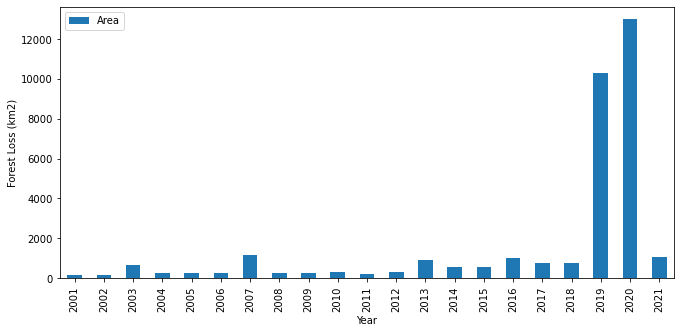

In [11]:
class_areas.plot(x ='Year', y='Area', kind='bar', figsize=(11,5))
plt.ylabel('Forest Loss (km2)')

<div class="alert alert-block alert-danger"> 

## Exercise 2

- Select all of Australia as your ROI and then calculate annual forest loss for the whole period of data availability (2000-2021) and plot the results. Then, discuss in which year the region shows more forest loss and why? 
    
- After quantifying forest loss in Australia, compare the results with the country you selected in Exercise 1. Briefly discuss the drivers of forest loss in each country different?
    
    
</div>    

<div class="alert alert-block alert-danger"> 

## Exercise 3

- Create a multitemporal color composite to highlight areas where there have experienced more deforestation in the resulting map. You can pick up the first year of the time series and the last year (or two consecutive years).
 
    
</div>    

## References
This is where the references go. For exmaple:

* Hansen, M. C., Potapov, P. V., Moore, R., Hancher, M., Turubanova, S. A., Tyukavina, A., ... & Townshend, J. (2013). High-resolution global maps of 21st-century forest cover change. science, 342(6160), 850-853.

* Wu, Q., (2020). geemap: A Python package for interactive mapping with Google Earth Engine. The Journal of Open Source Software, 5(51), 2305. https://doi.org/10.21105/joss.02305

## Additional information

**License:** The code in this notebook was initially created by the team at [Digital Earth Australia](https://github.com/GeoscienceAustralia/dea-notebooks), and has been modified by Abolfazl Abdollahi. The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 

**Contact:** If you need assistance, please post a question on the ENGN3903 Wattle (**check**) site 

**Last modified:** August 2022